In [28]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xesmf as xe

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.ilamb_functions as ilamb
import fates_calibration_library.plotting_functions as plotting
import fates_calibration_library.utils as utils

In [2]:
import importlib
import fates_calibration_library.analysis_functions
importlib.reload(fates_calibration_library.analysis_functions)

<module 'fates_calibration_library.analysis_functions' from '/glade/work/afoster/FATES_calibration/fates_calibration_library/fates_calibration_library/analysis_functions.py'>

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='04:00:00',                                       # Amount of wall time
    interface='ext')

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45233 instead
  warnings.warn(


In [3]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/45233/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/45233/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.187:37771,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/45233/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
fates_vars = ['FATES_FRACTION', 'FATES_GPP', 'FATES_LAI', 
             'QVEGE', 'QVEGT', 'QSOIL', 'EFLX_LH_TOT', 'FSH', 
             'QRUNOFF', 'RAIN', 'SNOW', 'H2OSNO', 'TSOI',
             'SOILWATER_10CM', 'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'FGR12',
             'TSA', 'TREFMXAV', 'TREFMNAV', 'RH2M']

In [52]:
# sparse grid clustering file
grid_dir = '/glade/work/afoster/FATES_calibration/surfdata'
grid_file = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
sparse_grid = xr.open_dataset(os.path.join(grid_dir, grid_file))

# sparse grid whittaker biomes
whittaker_ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/whittaker/whitkey.nc')

# fetch the sparsegrid landarea - needed for unit conversion
land_area_file = '/glade/work/afoster/FATES_calibration/CLM5PPE/postp/sparsegrid_landarea.nc'
land_area = xr.open_dataset(land_area_file).landarea

# create a global land frac and area grid
land_frac_ds = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist",
                            "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')


# config file with conversion information in it
var_config = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/model_conversion.yaml'
var_dict = utils.get_config_file(var_config)

# ilamb observations
ilamb_config_file = '/glade/work/afoster/FATES_calibration/fates_calibration_library/configs/ilamb_conversion.yaml'
ilamb_config = utils.get_config_file(ilamb_config_file)
ilamb_obs = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/all_ILAMB_obs.nc')

In [18]:
def quick_map(dat, cmap, vmin=None, vmax=None):
    figure, ax = plt.subplots(
        1,
        1,
        figsize=(13, 6),
        subplot_kw=dict(projection=ccrs.Robinson()),
        layout="compressed",
    )
   # ax.coastlines()
   # ax.add_feature(
   #     cfeature.NaturalEarthFeature("physical", "ocean", "110m", facecolor="gray")
   # )
    # plot the color mesh
    pcm = ax.pcolormesh(
        dat.lon,
        dat.lat,
        dat,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )
    cbar = figure.colorbar(pcm, ax=ax, fraction=0.03, orientation="horizontal")

In [26]:
# read in regions
region = xr.open_dataset(
    os.path.join('/glade/campaign/cesm/community/lmwg/diag/ILAMB/DATA', "regions/GlobalLandNoAnt.nc")
)
# swap out 0.0 (land) for 1.0
region["ids"] = xr.where(region.ids == 0.0, 1.0, 0.0)

In [6]:
# FATES sparse grid run - latest tag
fates_crujra_dir = '/glade/derecho/scratch/afoster/archive/ctsm60SP_fates_sparse_crujra/lnd/hist'
fates_crujra = analysis.post_process_ds(fates_crujra_dir, fates_vars, whittaker_ds,
                                     years=[2000, 2015], run_dict={'filter_nyears': 20})

In [86]:

obs_var = 'ALBEDO'

In [87]:
var_name = 'FSR'
mod_da = fates_crujra[var_name]
da_glob = analysis.global_from_sparse(sparse_grid, mod_da, fates_crujra)
fsr_ann = (analysis.calculate_annual_mean(da_glob, var_dict[var_name]['time_conversion_factor']).mean(dim='year'))

In [88]:
var_name = 'FSDS'
mod_da = fates_crujra[var_name]
da_glob = analysis.global_from_sparse(sparse_grid, mod_da, fates_crujra)
fsds_ann = (analysis.calculate_annual_mean(da_glob, var_dict[var_name]['time_conversion_factor']).mean(dim='year'))

In [89]:
alb_ann = fsr_ann/fsds_ann

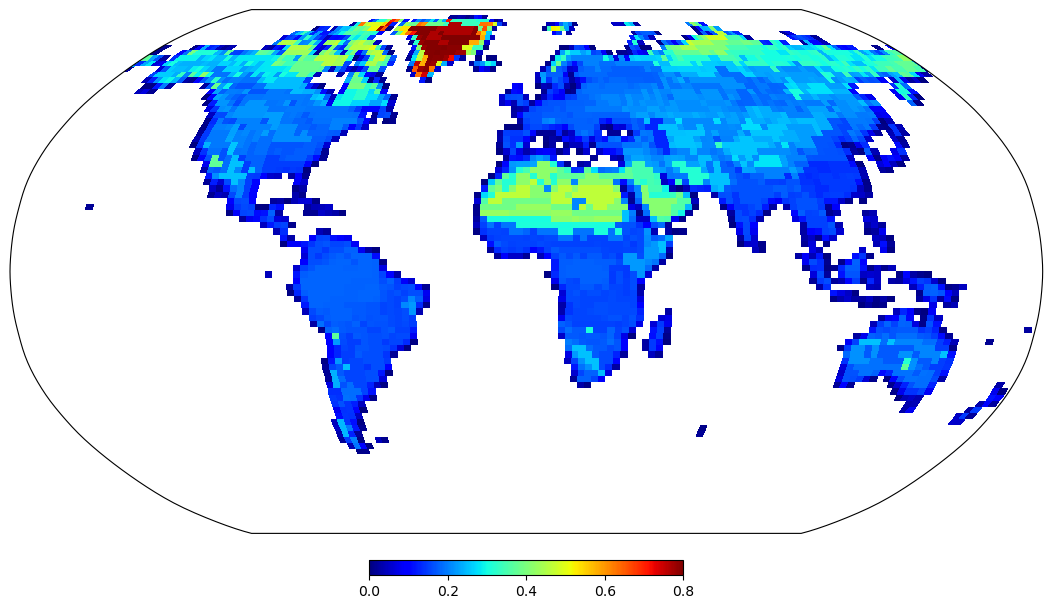

In [91]:
quick_map(alb_ann*target_grid.landfrac, 'jet', vmin=0.0, vmax=0.8)

In [76]:
analysis.area_mean(da_ann, var_dict[var_name]['area_conversion_factor'], target_grid.land_area)

<xarray.DataArray ()>
array(0.2458431)

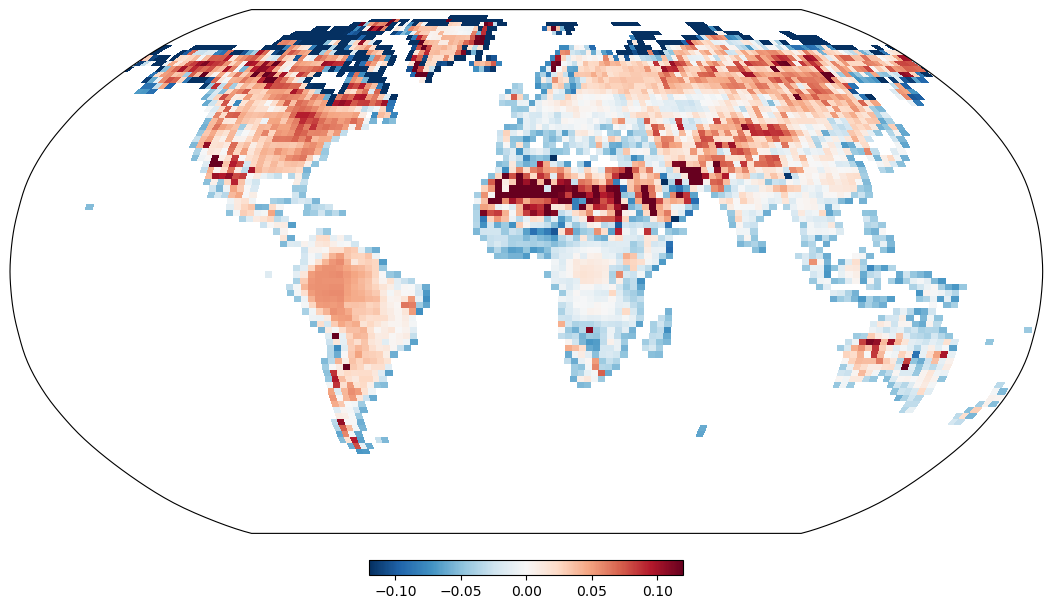

In [103]:
model = 'GEWEX.SRB'
obs_var = 'ASA'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[obs_var]['var'], ilamb_config[obs_var]['models']).sel(model=model)
diff = alb_ann*target_grid.landfrac - ilamb_var
quick_map(diff, 'RdBu_r', vmin=-0.12, vmax=0.12)

In [ ]:
diff*target.land

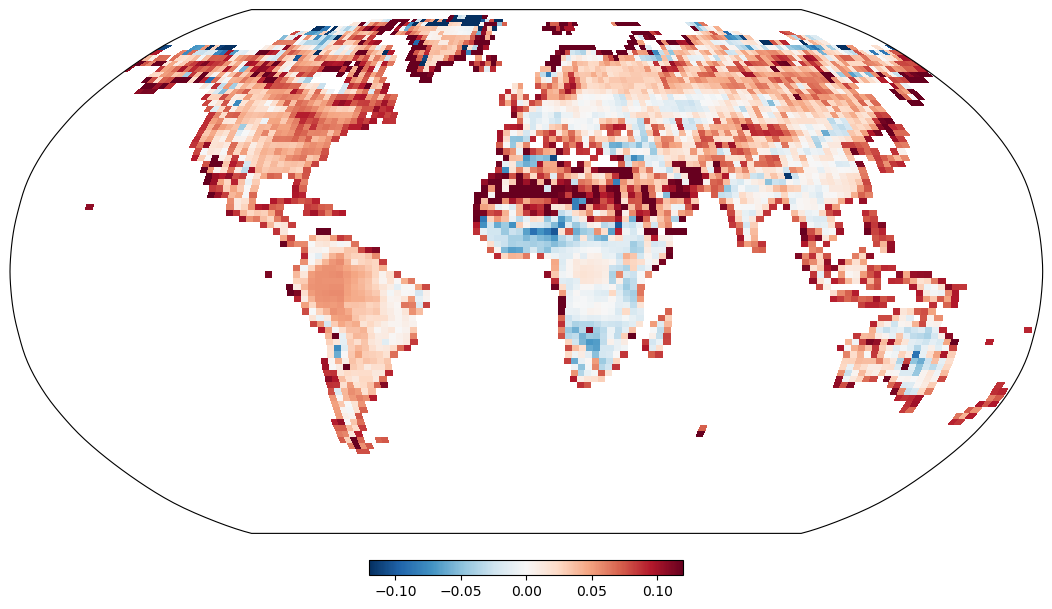

In [104]:
model = 'GEWEX.SRB'
obs_var = 'ASA'
ilamb_var = ilamb.get_model_da(ilamb_obs, ilamb_config[obs_var]['var'], ilamb_config[obs_var]['models']).sel(model=model)
diff = alb_ann - ilamb_var
quick_map(diff, 'RdBu_r', vmin=-0.12, vmax=0.12)